### Imports

In [1]:
import os
import pandas as pd
import warnings
from PIL import Image

warnings.filterwarnings('ignore')

### Load data

In [2]:
os.chdir('..')

In [3]:
# 'test_results'
experiment_name = input('Provide the name of the experiment folder')

In [4]:
evaluation_file = f'data/results/{experiment_name}/evaluation.tsv'

In [6]:
results = pd.read_csv(evaluation_file, sep='\t')

In [7]:
results.head()

,prompt_id,image_id,clip_score,user_prompt,optimized_prompt,caption,image_path,spice_score,terminated,best_image
0,34,0,0.848626,one child on a couch,one child on a couch,painting of a girl sitting on a couch with a c...,data/results/full_experiment_V1_parti/000034/i...,0.200000,0,1
1,34,1,0.659501,one child on a couch,A young girl relaxing on a couch,there is a young girl laying on a couch with h...,data/results/full_experiment_V1_parti/000034/i...,0.200000,0,0
2,34,2,0.589471,one child on a couch,A child sitting comfortably on a couch with a ...,there is a woman sitting on a couch with her l...,data/results/full_experiment_V1_parti/000034/i...,0.222222,0,0
3,34,3,0.927252,one child on a couch,A young child lounging comfortably on a plush ...,there is a small child laying on a couch with ...,data/results/full_experiment_V1_parti/000034/i...,0.444444,1,0
4,34,4,0.689970,one child on a couch,A young child sitting happily on a comfortable...,there is a little girl sitting on a couch with...,data/results/full_experiment_V1_parti/000034/i...,0.222222,0,0


In [9]:
# Define columns with scores
scores = ['clip_score','spice_score','img_sim_score']
# scores = ['clip_score','spice_score'] # for parti prompts results

### Results

In [51]:
#prompt_num = results['prompt_id'].nunique()
#optimization_step_num = results.groupby(['prompt_id'])['image_id'].count().max()

#### Average scores

In [10]:
# Average scores for all prompts
results[scores].mean()

clip_score     0.763031
spice_score    0.147960
dtype: float64

#### Average scores per prompt

In [11]:
# Average scores per prompt
results.groupby(['prompt_id','user_prompt'])[scores].mean()

,,clip_score,spice_score
prompt_id,user_prompt,,
0,bond,0.579237,0.000000
1,0,0.482822,0.000000
2,a walnut,0.727182,0.000000
3,a laptop,0.653306,0.037037
4,a horse,0.728545,0.333333
5,a toaster,0.784581,0.000000
6,a stone path,0.759866,0.359259
7,a book,0.609795,0.163889
8,the Parthenon,0.707822,0.037037


#### Early stopping

In [12]:
# Percentage of prompts that were stopped
results.groupby(['prompt_id'])['terminated'].max().mean()

0.49019607843137253

In [13]:
# Most often terminations step based on best image
results[results['terminated'] == True]['image_id'].value_counts().sort_values(ascending=False)

image_id
0    13
2     5
3     3
4     3
1     1
Name: count, dtype: int64

In [14]:
# Average termination step for based image
results[results['terminated'] == True]['image_id'].mean()

1.28

In [13]:
# Average scores for stopped prompts
results[results['terminated'] == True][scores].mean()

clip_score       0.830490
spice_score      0.399771
img_sim_score    0.563393
dtype: float64

#### Best Image

In [14]:
# Most often terminations step based on best image
results[results['best_image'] == True]['image_id'].value_counts().sort_values(ascending=False)

image_id
1    14
0    13
2     9
3     9
4     4
5     1
Name: count, dtype: int64

In [15]:
# Average termination step for based image
results[results['best_image'] == True]['image_id'].mean()

1.6

In [16]:
# Average scores for best image
results[results['best_image'] == True][scores].mean()

clip_score       0.812913
spice_score      0.365158
img_sim_score    0.553264
dtype: float64

Iteration: 1
Original prompt: A woman walking across a street holding a pink umbrella.
Generated image:


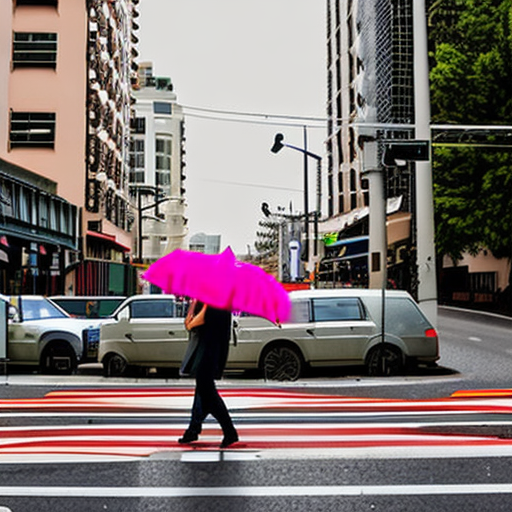

Caption: araffe crossing the street with a pink umbrella in the rain
#################################################################################
Iteration: 2
TERMINATED at this step
Optimized prompt: A woman walking on a rainy street, gracefully holding a pink umbrella.
Generated image:


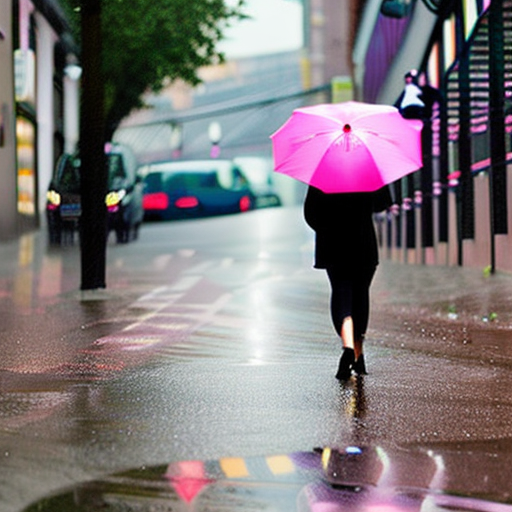

Caption: woman walking down a wet sidewalk with an umbrella in the rain
#################################################################################
Iteration: 3
BEST IMAGE according to LLM
Optimized prompt: A woman confidently strolling down a busy intersection with a bright pink umbrella portrayed as the center of attention.
Generated image:


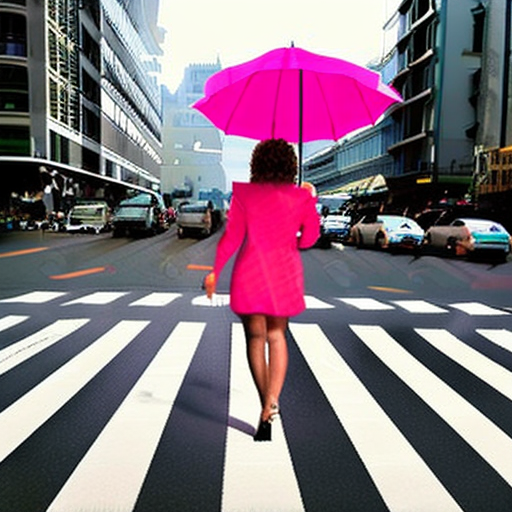

Caption: woman in pink coat walking across street with pink umbrella
#################################################################################
Iteration: 4
Optimized prompt: A woman gracefully carrying a pink umbrella while strolling across a bustling city street.
Generated image:


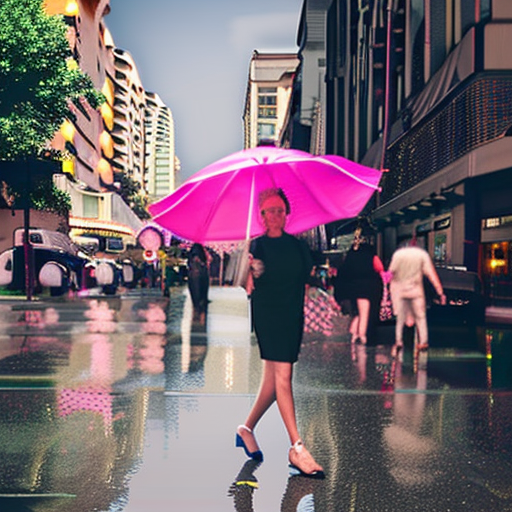

Caption: araffe woman walking in the rain with an umbrella in the city
#################################################################################
Iteration: 5
Optimized prompt: A woman walking across a busy street during a sunny day while holding a bright pink umbrella.
Generated image:


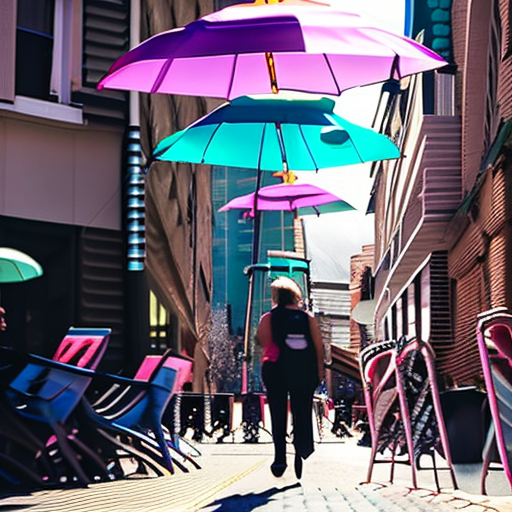

Caption: araffes are walking down a sidewalk with umbrellas hanging from them
#################################################################################
Iteration: 6
Optimized prompt: A woman walking across a rain-soaked street with a pink umbrella.
Generated image:


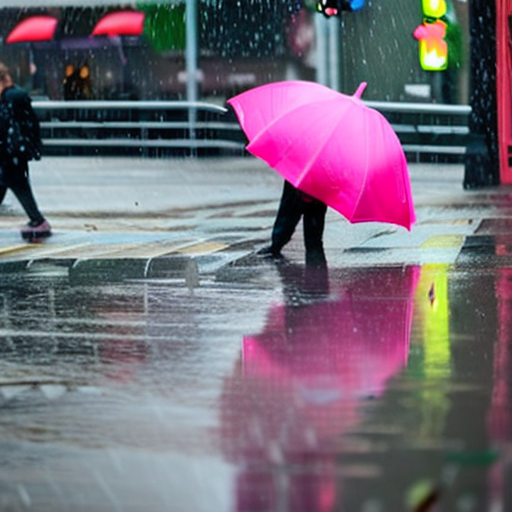

Caption: nan
#################################################################################


In [17]:
prompt_id = int(input("Provide prompt_id"))
for idx, row in results[results['prompt_id'] == prompt_id].reset_index().iterrows():
    print('Iteration:', idx + 1)
    if row['terminated'] == 1:
        print('TERMINATED at this step')
    if row['best_image'] == 1:
        print('BEST IMAGE according to LLM')
    if idx == 0:
        print('Original prompt:', row['optimized_prompt'])
    else:
        print('Optimized prompt:', row['optimized_prompt'])
    print('Generated image:')
    image = Image.open(row['image_path'])
    display(image)
    print('Caption:', row['caption'])
    print('#################################################################################')